<a href="https://colab.research.google.com/github/nagen01/AIML/blob/master/BERT_Fine_Tuning_for_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
!pip install transformers

     |████████████████████████████████| 665kB 3.2MB/s 
     |████████████████████████████████| 3.8MB 18.1MB/s 
     |████████████████████████████████| 1.1MB 37.5MB/s 
     |████████████████████████████████| 890kB 36.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=717633dcb0f9e8e524bf4369e7629d9a3e675357b161aa204c12a506a656cd58
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:

import pandas as pd

# Load the dataset into a pandas dataframe.
dataset_loc = "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv"
df = pd.read_csv(dataset_loc , delimiter='\t', header= None, names = ["sentences", "labels"])
#df = pd.read_csv("https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv" , delimiter='\t', header= None, names = {'sentences', 'labels'})
#print(df.head())
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
print(df.sample(10))

training_set_len = round(0.9*len(df))
df_train = df[:training_set_len]
df_test = df[training_set_len:]

Number of training sentences: 6,920

                                              sentences  labels
5196  another love story in 2002 's remarkable proce...       1
2940                           more trifle than triumph       0
4838  there 's no point in extracting the bare bones...       0
1360  director shekhar kapur and screenwriters micha...       0
1277  whenever you think you 've figured out late ma...       1
1897  as predictable as the outcome of a globetrotte...       0
291   the redeeming feature of chan 's films has alw...       0
5396    `` the best disney movie since the lion king ''       1
458                                     decent but dull       0
6110  due to stodgy , soap opera ish dialogue , the ...       0


In [5]:
df_train

,sentences,labels
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
6223,"no charm , no laughs , no fun , no reason to w...",0
6224,"thanks largely to williams , all the interesti...",0
6225,what might have emerged as hilarious lunacy in...,0
6226,it would take a complete moron to foul up a sc...,0


In [0]:
# Get the lists of sentences and their labels.
sentences = df_train.sentences.values
labels = df_train.labels.values

In [7]:
print(sentences)

['a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films'
 'apparently reassembled from the cutting room floor of any given daytime soap'
 "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes"
 ...
 "what might have emerged as hilarious lunacy in the hands of woody allen or mel brooks lrb at least during their '70s heyday rrb comes across as lame and sophomoric in this debut indie feature"
 "it would take a complete moron to foul up a screen adaptation of oscar wilde 's classic satire"
 'jackass is a vulgar and cheap looking version of candid camera staged for the marquis de sade set']


In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [9]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
  print(sent)
  # `encode` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  encoded_sent = tokenizer.encode(
                    sent,                      # Sentence to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                    # This function also supports truncation and conversion
                    # to pytorch tensors, but we need to do padding, so we
                    # can't use these features :( .
                    #max_length = 128,          # Truncate all sentences.
                    #return_tensors = 'pt',     # Return pytorch tensors.
                )
  
  # Add the encoded sentence to the list.
  input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Streaming output truncated to the last 5000 lines.
it really is a shame that more wo n't get an opportunity to embrace small , sweet ` evelyn '
caviezel embodies the transformation of his character completely
i found it slow , predictable and not very amusing
see it
as played by ryan gosling , danny is a frighteningly fascinating contradiction
the movie spends more time with schneider than with newcomer mcadams , even though her performance is more interesting lrb and funnier rrb than his
oh , and more entertaining , too
the genius of the work speaks volumes , offering up a hallucinatory dreamscape that frustrates and captivates
austin powers for the most part is extremely funny , the first part making up for any flaws that come later
a worthy addition to the cinematic canon , which , at last count , numbered 52 different versions
if you like blood , guts and crazy beasts stalking men with guns though you will likely enjoy this monster
it is a popcorn film , not a must own , or even a 

In [10]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = max([len(sen) for sen in input_ids]) + 1  #Adding "1" just for simplicity
print('Max sentence length: ', MAX_LEN)

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

Max sentence length:  68

Padding/truncating all sentences to 68 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress 

Define a helper function for calculating accuracy.

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [20]:
print(device)

cuda


In [21]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    176.    Elapsed: 0:00:30.
  Batch    80  of    176.    Elapsed: 0:01:00.
  Batch   120  of    176.    Elapsed: 0:01:30.
  Batch   160  of    176.    Elapsed: 0:02:00.

  Average training loss: 0.39
  Training epcoh took: 0:02:11

Running Validation...
  Accuracy: 0.89
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    176.    Elapsed: 0:00:30.
  Batch    80  of    176.    Elapsed: 0:00:59.
  Batch   120  of    176.    Elapsed: 0:01:29.
  Batch   160  of    176.    Elapsed: 0:01:59.

  Average training loss: 0.17
  Training epcoh took: 0:02:10

Running Validation...
  Accuracy: 0.90
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    176.    Elapsed: 0:00:30.
  Batch    80  of    176.    Elapsed: 0:00:59.
  Batch   120  of    176.    Elapsed: 0:01:29.
  Batch   160  of    176.    Elapsed: 0:01:59.

  Average training loss: 0.09
  Training epcoh t

Let's take a look at our training loss over all batches:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


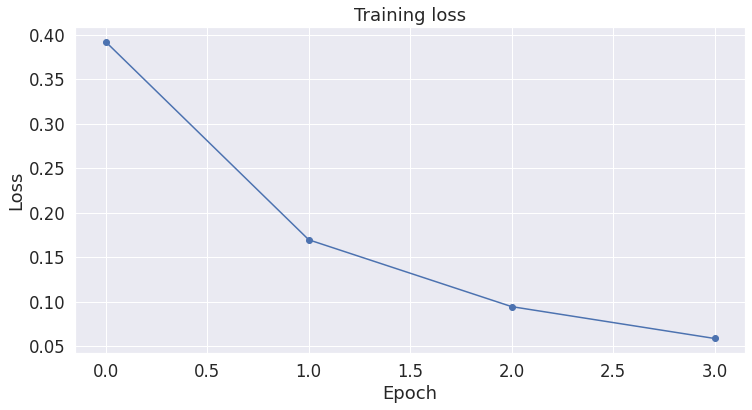

In [22]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists for test
sentences = df_test.sentences.values
labels = df_test.labels.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [24]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 692 test sentences...
    DONE.


In [0]:
#predictions

In [26]:
print('Positive samples: %d of %d (%.2f%%)' % (df.labels.sum(), len(df.labels), (df.labels.sum() / len(df.labels) * 100.0)))

Positive samples: 3610 of 6920 (52.17%)


In [27]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [28]:
pred_labels_i

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [29]:
matthews_set

[0.875,
 0.6999132392733555,
 0.5393598899705937,
 0.828416869579514,
 0.8126375006351424,
 0.7559289460184544,
 0.938872452190116,
 0.8140915784106943,
 0.873015873015873,
 0.8096598849105344,
 0.6625413488689132,
 0.8140915784106943,
 0.717973623597536,
 0.6070347255016324,
 1.0,
 0.8823529411764706,
 0.9393364366277243,
 0.7568627450980392,
 0.6813969328454993,
 1.0,
 0.8819171036881969,
 1.0]

In [30]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.809


In [31]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [32]:
output_dir = './model_save/'

# Load a trained model and vocabulary that you have fine-tuned
l_model = BertForSequenceClassification.from_pretrained(output_dir)
l_tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [33]:
#input_sent = "Wipro Ltd's run of sluggish growth continues, with the company reporting year-on-year growth of merely 3.3%"
#input_sent = "Covid19 pushed world economy towards recession"
#input_sent = "Explosion at Foxcon factory kills hundreds"
input_sent = "Apple launches new phone with great reviews"
max_len = 512
i_df = pd.DataFrame([input_sent])
i_tokenized = i_df[0].apply((lambda x:l_tokenizer.encode(x, add_special_tokens=True)))
i_padded = np.array([i + [0]*(max_len-len(i)) for i in i_tokenized.values])
i_attention_mask = np.where(i_padded != 0, 1, 0)
i_input_ids = torch.tensor(i_padded)  
i_attention_mask = torch.tensor(i_attention_mask)
i_predictions = []
with torch.no_grad():
    i_last_hidden_states = l_model(i_input_ids, attention_mask=i_attention_mask)

i_logits = i_last_hidden_states[0]

# Move logits and labels to CPU
#logits = logits.detach().cpu().numpy()
#label_ids = b_labels.to('cpu').numpy()

# Store predictions and true labels
i_predictions.append(i_logits)
i_pred_label = np.argmax(i_predictions[0], axis=1).flatten()

#i_features = i_last_hidden_states[0][:,0,:].numpy()
#print(lr_clf.predict(i_features)[0])
print(i_predictions)
print(i_pred_label[0])

[tensor([[-2.8664,  3.0429]])]
tensor(1)


In [42]:
import nltk
nltk.download('punkt')
#input_sent = "Wipro Ltd's run of sluggish growth continues, with the company reporting year-on-year growth of merely 3.3%"
sentences = "Wipro, India's third-largest IT services exporter, has acquired the India operations of US-based technology company Alight Solutions for an estimated $117 million. Explosion at Foxcon factory kills hundreds. Apple launches new phone with great reviews"
max_len = 512
n = 0
sentiment = 0
for input_sent in nltk.sent_tokenize(sentences):
    n += 1
    i_df = pd.DataFrame([input_sent])
    i_tokenized = i_df[0].apply((lambda x:l_tokenizer.encode(x, add_special_tokens=True)))
    i_padded = np.array([i + [0]*(max_len-len(i)) for i in i_tokenized.values])
    i_attention_mask = np.where(i_padded != 0, 1, 0)
    i_input_ids = torch.tensor(i_padded)  
    i_attention_mask = torch.tensor(i_attention_mask)
    i_predictions = []
    with torch.no_grad():
        i_last_hidden_states = l_model(i_input_ids, attention_mask=i_attention_mask)

    i_logits = i_last_hidden_states[0]

    # Move logits and labels to CPU
    #logits = logits.detach().cpu().numpy()
    #label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    i_predictions.append(i_logits)
    i_pred_label = np.argmax(i_predictions[0], axis=1).flatten()

    #i_features = i_last_hidden_states[0][:,0,:].numpy()
    #print(lr_clf.predict(i_features)[0])
    print(i_predictions)
    print(i_pred_label[0])
    sentiment += i_pred_label[0].numpy()
print("\n")
print(sentiment)
print("\n")
print(sentiment/n)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[tensor([[-0.8808,  0.1586]])]
tensor(1)
[tensor([[ 1.8158, -2.4371]])]
tensor(0)
[tensor([[-2.8664,  3.0429]])]
tensor(1)


2


0.6666666666666666
